Learning how pytorch works...

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support   
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [9]:
LR_RATE = 0.001
EPOCHS = 5
BATCH_SIZE = 16
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# download dataset and transform it

transform =  transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

num_classes = len(classes)

In [12]:
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


tensor([6, 6, 1, 8, 3, 3, 7, 5, 3, 4, 3, 9, 3, 3, 3, 9])
Shirt  Shirt  Trouser  Bag
tensor([6, 6, 1, 8, 3, 3, 7, 5, 3, 4, 3, 9, 3, 3, 3, 9])


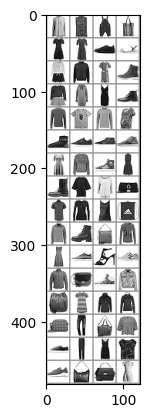

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

temp = [images]
lbls = [labels]
print(labels)
for i in range(3):
    img, lab = next(dataiter)
    #images = torch.cat((images, img), dim=0)
    temp.append(next(dataiter)[0])

images = torch.cat(temp, dim=0)
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images, nrow=4)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))
print(labels)

In [8]:
from torchvision.models import MobileNet_V2_Weights

model = torch.hub.load('pytorch/vision:v0.16.1', 'mobilenet_v2', weights=MobileNet_V2_Weights.DEFAULT)

Using cache found in /home/jason/.cache/torch/hub/pytorch_vision_v0.16.1


In [42]:
# Change output of classifier to be num_classes
print(model.classifier[1])
model.classifier[1] = torch.nn.Linear(1280, num_classes)
print(model.classifier[1])

torch.nn.init.xavier_uniform_(model.classifier[1].weight)
torch.nn.init.zeros_(model.classifier[1].bias)

print("\n")

print(model.features[0])

Linear(in_features=1280, out_features=1000, bias=True)
Linear(in_features=1280, out_features=10, bias=True)


Conv2dNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)


In [43]:
print(model.features[0][0].weight.size())
tempWeights = torch.nn.Parameter(model.features[0][0].weight[:,:1,:,:])
print(tempWeights.size())
model.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=(1,1), bias=False)
model.features[0][0].weight = tempWeights

torch.Size([32, 3, 3, 3])
torch.Size([32, 1, 3, 3])


In [44]:
print(model.features[0])

Conv2dNormActivation(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)


In [45]:
model = model.to('cuda')

In [46]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.0079, 0.6809, 0.4404, 0.1687, 0.5436, 0.2074, 0.0231, 0.1086, 0.8018,
         0.5468],
        [0.9431, 0.0959, 0.8485, 0.5339, 0.0433, 0.4519, 0.6392, 0.1934, 0.6825,
         0.1184],
        [0.6983, 0.5337, 0.9722, 0.3183, 0.3425, 0.2447, 0.1098, 0.5137, 0.0623,
         0.0294],
        [0.4644, 0.4832, 0.7975, 0.8824, 0.2215, 0.1584, 0.0920, 0.8889, 0.3922,
         0.9688]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.1929149627685547


In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE, betas=[BETA1, BETA2], eps=EPSILON)

In [48]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # training_loader = dataloader object
    # remember: 1 epoch = 1 pass through the entire dataset!
    for i, data in enumerate(training_loader):
        # extract from batch
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # compute loss & its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # adjust the weights
        optimizer.step()
        
        # add loss to cumilative loss
        running_loss += loss.item()
        
        if i % 1000 == 999:
            last_loss = running_loss / 1000   # loss per batch (of 1000)
            print(f"   batch: {i+1}    loss: {last_loss}")
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        
    return last_loss

In [49]:
timestamp = datetime.now().strftime('%Y%m%d_%H_%M_%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


   batch: 1000    loss: 1.0251609116345644
   batch: 2000    loss: 0.7111870496198535
   batch: 3000    loss: 0.6181988145932555
LOSS train 0.6181988145932555 valid 0.4722687304019928
EPOCH 2:
   batch: 1000    loss: 0.5320190309658647
   batch: 2000    loss: 0.4838590936008841
   batch: 3000    loss: 0.4768116005733609
LOSS train 0.4768116005733609 valid 0.4173855781555176
EPOCH 3:
   batch: 1000    loss: 0.4394875835813582
   batch: 2000    loss: 0.401083823569119
   batch: 3000    loss: 0.39895823886990545
LOSS train 0.39895823886990545 valid 0.34760957956314087
EPOCH 4:
   batch: 1000    loss: 0.3603127396311611
   batch: 2000    loss: 0.36417096270434557
   batch: 3000    loss: 0.336595894953236
LOSS train 0.336595894953236 valid 0.3011375069618225
EPOCH 5:
   batch: 1000    loss: 0.3225252996571362
   batch: 2000    loss: 0.3258220368716866
   batch: 3000    loss: 0.31967931854259224
LOSS train 0.31967931854259224 valid 0.28342118859291077
